---
title: "Intro to Convolution Neural Networks"
date: "July 30, 2024"
categories: [cnns, deep-learning]
format:
  html:
    toc: true
    toc-depth: 3
    # html-math-method: katex
    # css: ../../styles.css
    code-fold: true
  ipynb: default
  # markdown: default
execute:
  warning: false
---

Hello everyone, in this notebook we're going to understand the bare fundamentals of convolutional neural networks. We'll start by getting to know the convolutional operation itself and then proceed to make a very simple CNN model. 

The pre-requisites for this post are:

- Basic understanding of python, numpy and torch.
- Basic understanding of neural networks and feed forward networks.

<!-- Welcome to the land of vision in deep learning. Gone are the days you need to look at 10 types of thresholding and 20 types of data pre-processing and apply a logistic classifier on the outputs of a cnn feature extractor. These days you can just load a pretrained model and watch a decaying training and validation loss and feel good about yourself.

Turns out, this comfort doesnt last long. You eventually get around to understand what these models actually are because you need to! 
And when it comes to vision, you surely cannot leave out CNNs. Sure its all transformers nowadays but CNNs or convolutional neural networks were essentially the first deep learning models to make a significant impact in the field of computer vision and most would agree started the whole deep learning wave in the modern era. AlexNet, VGG, resnets would be considered the pioneer models in this field.

Now you might ask: All this sounds interesting Deepam, but what the hell is a convolution? Let us understand convolutions and build a simple CNN model from scratch. 

The pre-requisites for this post are:

- Basic understanding of python, numpy and torch.
- Basic understanding of neural networks and feed forward networks.
 -->

## Convolutions

Convolution is a mathematical operation that combines two signals to produce a third signal, representing how one signal modifies the other. In general terms, convolution is used to apply a filter (or kernel) to a signal or data.

For discrete signals, the convolution of two signals $f[n]$ and $g[n]$ is defined as:

$$(f * g)[n] = \sum_{m=-\infty}^{\infty} f[m] \cdot g[n - m]$$

Where:
- $f[n]$ is the input signal,
- $g[n]$ is the filter (or kernel),
- $(f * g)[n]$ is the resulting convolved signal.

This operation involves flipping the filter $g[n]$, shifting it across the input signal $f[n]$, multiplying the overlapping values, and summing the results to produce the output signal.

#### Steps in Convolution

Convolution involves the following steps:

1. **Prepare the Kernel**: Take the transpose(flip) of the kernel $(g)$ along the resolution dimensions ($H,W$).[see why](https://dsp.stackexchange.com/questions/5992/flipping-the-impulse-response-in-convolution/6355#6355)

2. **Align and Slide**: Position the flipped kernel at the start of the input signal $(f)$. Then, systematically slide it across the entire length of $(f)$.

3. **Multiply**: At each position, perform element-wise multiplication between the overlapping portions of the flipped kernel and the input signal.

4. **Sum**: Add up all the products from step 3 to get a single value. This value represents the convolution result at the current position.

5. **Record and Repeat**: Store the sum as an element in the output signal, then move the kernel to the next position and repeat steps 3-5 until the entire input signal has been covered.

The resulting output signal represents how the kernel has "filtered" or modified the input signal, highlighting certain features or patterns based on the kernel's characteristics.

This process can be extended to 2D (for images) or higher dimensions, where the kernel slides over the input in all dimensions.

For a 1d array this might look like this: 

In [73]:

import numpy as np 

f = np.array([1,2,3,-1, 10,1])
g = np.array([1,0,-1,1])
inverted_g = g[::-1]

print(f"f: {f}")
print(f"g: {g}")
print(f"inverted_g, g`: {inverted_g}")

window_size = g.shape[0]
result = []

print("\nSteps in convolution, slide g` over f in a loop:")
print("'* is dot product' \n")
print("result = f*g = [_ _ _ _]\n")
for idx, i in enumerate(range(len(f)-window_size+1)):
    slice_of_f = f[i:i+window_size]
    print(f"step {idx+1}. \n{slice_of_f} * {inverted_g} = {slice_of_f.dot(inverted_g)}")
    # print(f"step {idx+1}.2 sum({slice_of_f * inverted_g}) = {np.sum(slice_of_f * inverted_g)}")
    result.append(np.sum(slice_of_f * inverted_g))
    print(f"result[{i+1}]: {result[i]}\n")

print(f"result: {result}")

f: [ 1  2  3 -1 10  1]
g: [ 1  0 -1  1]
inverted_g, g`: [ 1 -1  0  1]

Steps in convolution, slide g` over f in a loop:
'* is dot product' 

result = f*g = [_ _ _ _]

step 1. 
[ 1  2  3 -1] * [ 1 -1  0  1] = -2
result[1]: -2

step 2. 
[ 2  3 -1 10] * [ 1 -1  0  1] = 9
result[2]: 9

step 3. 
[ 3 -1 10  1] * [ 1 -1  0  1] = 5
result[3]: 5

result: [-2, 9, 5]


Consider `len(f)=M` & `len(g)=N`. 
We also have a few types of convolutions, based on how much padding is added to the input signal: 

1. **Valid Convolution**: 
    - The output is smaller than the input. No padding is applied.
    - Mode 'valid' returns output of length
      ``max(M, N) - min(M, N) + 1``.
    


2. **Same Convolution**: 
    - Padding is applied to keep the output size the same as the input. 
    - Mode 'same' returns output of length ``max(M, N)``. 


In [88]:
print(f"np.convolve(f,g, mode='same') -> {np.convolve(f,g, mode='same')}")

np.convolve(f,g, mode='same') -> [  2   2  -2   9   5 -11]



3. **Full Convolution**: 
    - Maximum padding is applied. 
    - This returns the convolution at each point of overlap, with an output shape of (N+M-1,).

In [89]:
print(f"full f*g \n-> {np.pad(f,len(g)-1)} * {g[::-1]}")
print(f"-> {np.convolve(f,g, mode='full')}")

full f*g 
-> [ 0  0  0  1  2  3 -1 10  1  0  0  0] * [ 1 -1  0  1]
-> [  1   2   2  -2   9   5 -11   9   1]


That wasnt so hard was it? Lets look at an example for 2d arrays.  

Lets take 2 matrices $f$ & $g$ of shapes (4,4) and (3,3). Since $g$ is a square kernel with side=3, we say it has size 3.
First we need to flip the $g$ both horizontally and vertically. Then, for each $g$ sized block in $f$, we do element-wise multiplication then summation.


Lets see how this works.

![2d conv](https://miro.medium.com/v2/resize:fit:786/format:webp/1*hOI0jW3CcS_yuxcmJIYjKw.gif){width=300 style="display: block; margin: auto;"}

In [90]:
#| code-fold: true
f = np.random.rand(4,4)
g = np.array([[1,0,-1],[2,0,-2],[3,0,-3]])
inverted_g = g[::-1, ::-1]
print(f"(f): \n{f}\n")
print(f"(g): \n{g}\n")
print(f"(g`): \n{inverted_g}\n")

(f): 
[[0.56832851 0.1169398  0.62616176 0.94949466]
 [0.06633587 0.83629314 0.79893411 0.07711767]
 [0.11524299 0.48151466 0.3024186  0.34043628]
 [0.76204227 0.80463651 0.4008499  0.4356766 ]]

(g): 
[[ 1  0 -1]
 [ 2  0 -2]
 [ 3  0 -3]]

(g`): 
[[-3  0  3]
 [-2  0  2]
 [-1  0  1]]



In [91]:
#| code-fold: true
f_rows, f_columns = f.shape 
g_rows, g_columns = g.shape

result = np.zeros((f_rows-g_rows+1, f_columns-g_columns+1))
print(f"Convolution steps:")
for i in range(f_rows-g_rows+1):
    for j in range(f_columns-g_columns+1):
        item = f[i:i+g_rows, j:j+g_columns] * inverted_g
        if i<3 and j==0:
            print(f"step {i+j+1}\n-> f[{i}:{i+g_rows}, {j}:{j+g_columns}] * g`: \n{item}")
            print(f"result[{i},{j}] -> {np.sum(item):.4f}\n")
        result[i,j] = np.sum(item)
print("... and so on.\n")
print(f"final result: \n{result}\n")

Convolution steps:
step 1
-> f[0:3, 0:3] * g`: 
[[-1.70498553  0.          1.87848528]
 [-0.13267174  0.          1.59786822]
 [-0.11524299  0.          0.3024186 ]]
result[0,0] -> 1.8259

step 2
-> f[1:4, 0:3] * g`: 
[[-0.1990076   0.          2.39680234]
 [-0.23048599  0.          0.60483719]
 [-0.76204227  0.          0.4008499 ]]
result[1,0] -> 2.2110

... and so on.

final result: 
[[ 1.82587185  0.83823527]
 [ 2.21095358 -2.92864308]]



**Padding**: Padding is now applied on both the height and width dimensions. 

**Stride**: You can see that the kernel shifts by one pixel everytime. This is the stride of this conv operation. It is generally applied symmetrically across $H$ & $W$. You can see how doubling the stride would reduce output size by half. In general, larger stride → Smaller output (since we're skipping pixels)

![1](https://lilianweng.github.io/posts/2017-12-15-object-recognition-part-2/numerical_no_padding_no_strides.gif){width=400 style="display: block; margin: auto;"}

![2](https://lilianweng.github.io/posts/2017-12-15-object-recognition-part-2/numerical_padding_strides.gif){width=400 style="display: block; margin: auto;"}


*Two examples of 2D convolution operation: 
    (1) no padding and 1x1 strides.
    (2) padding = 1 and 2x2 strides. (Image source: deeplearning.net)*

## Neural networks

Now that we clearly understand what a convolution is, lets get back to neural networks. Suppose you wanted to classify images before CNNs were developed. How would you do it? In most cases, you would use some pre-determined filters to extract features from the images and then use a fully connected network to classify the images. Those features could be:

1. Edge filters: Used to detect edges in images. Common edge detection filters include:
   - Sobel filter: Emphasizes horizontal or vertical edges
   - Prewitt filter: Similar to Sobel, but with different coefficients
   - Laplacian filter: Detects edges in all directions

2. Texture filters: Used to capture texture information:
   - Gabor filters: Detect specific frequencies and orientations
   - Laws' texture energy measures: A set of filters for texture analysis

3. Color histograms: Represent the distribution of colors in an image

4. SIFT (Scale-Invariant Feature Transform): Detects and describes local features in images

5. HOG (Histogram of Oriented Gradients): Counts occurrences of gradient orientations in localized portions of an image

6. Haar-like features: Used in face detection, these features look at rectangular regions and sum up pixel intensities

After applying these filters, you would typically:

1. Extract the resulting features
2. Possibly apply dimensionality reduction techniques like PCA
3. Feed the processed features into a classifier such as SVM, Random Forest, or a simple neural network

This approach, while effective for certain tasks, had limitations:
- Handcrafted features might not capture all relevant information
- The process was often computationally expensive
- Feature engineering required domain expertise

CNNs addressed these issues by learning the filters automatically during training, leading to more effective and adaptable vision models. Let us look at all the important components of a CNN in the next section.

## Convolutional layer


We now understand why handcrafted fatures are hard to come up with. Lets back up for a second and remember our old friends feed forward (FF) networks. What is the problem with using feed forward networks to process images? Specifically why dont we just give the FF network the raw pixels and let it learn?

As it turns out, there are quite a few things:

Suppose we have a (224,224,3) sized input-image. Thats a total of 224\*224\*3 = 150,528 data-points. suppose i want to have a output vector of length 1000 (classifier with 1k classes), this gives me a total of roughly 150k * 1k = 150 million parameters, where we have 1k parameters for each input pixel! That is a LOTT of parameters.

So how can we use the inherent nature of images and image-data to construct better models? We also learned convolutions in the previous section. Maybe that gives you some hint?

Pixel data is inherently very locally dependent. This is very different from tabular data, for example, a housing price dataset where each feature is largely independent of each other. By design feedforward networks do not allow for this kind of information to be shared between different data points in the network. This is beacause for each linear layer, a output shaped weight matrix is learned for each point in the input. This seems very inefficient. 

What if instead of treating each individual pixel as a different input, we treat a patch of pixels as a single input? This means we get one output item for a patch of pixels, and our weights can *"slide"* across an image to produce our output. And if that sounds like something we were doing earlier, you are right!

Enter convolution. The weights will basically be filters we learn. And since the same filter is applied to all the patches in a conv operation, there are a lot less pararmeters to learn.

We can learn a lot of filters that will interact with our image and get us some useful features which can then be fed to a FF network. 

A filter always has the same number of dimensions as the input. Images are 3 dimensional tensors $(H_{in}, W_{in}, C_{in})$. The kernel will then be a tensor of size $k,k, C_{in}$. A single step in their convolution that produces 1 output is the dot product between the kernel and a ($k,k$) window of the input image. Hence the output is a 2d matrix.

But we learn a lot of these filters, say $C_{out}$. So we get $C_{out}$ such 2d, matrices. So if we consider 

- input block shape -> $(H_{in}, W_{in}, C_{in})$
- filter shape -> $k, k, C_{in}$
- number of filters -> $C_{out}$ 
- The outputs will be a 3d tensor of shape $(H_{out}, W_{out}, C_{out})$, where $(H_{out}, W_{out}$ are determined by input resolution and the padding & stride of the convoution operation.


![](https://qph.cf2.quoracdn.net/main-qimg-b662a8fc3be57f76c708c171fcf29960){width=300 style="display: block; margin: auto;"}

<!-- But images are 3 dimensionsal you say! Sure they are -->
<!-- This is exactly what a convolutional layer does. It consists of a set of learnable filters that slide over the input image and compute the output. If the input image is of size $(H_{in}, W_{in}, C_{in})$, and we have $C_{out}$ filters of size $(k,k,C_{in})$, the output of the convolutional layer is of size $(H_{out}, W_{out}, C_{out})$. 
Each filter slides over the entire input volume and produces a 2d matrix of size $(H_{out}, W_{out})$. And this is done for all the filters in the layer. So the output of the convolutional layer is a 3d tensor of size $(H_{out}, W_{out}, C_{out})$. -->

<!-- Note that the filters will always have depth equal to the input volume's depth. -->


The number of parameters learned here would be $(k*k*C_{in}*C_{out})$. So for a conv layer with 64 filters of size (3x3) for an input image of size (224x224x3), we would have 1792 parameters, which is orders of magnitutde smaller already. Much more efficient isn't it?

<!-- 
1. Feed forward networks do not share information between different data points in the network. For example if X = [0,1,2,3] is a vector of input to the network, all the interactions between weights happen independently for each data point in one sample of data.
This works fine for tabular features of some data, because they actually are not dependent on their spatial postion wrt each other. The model will learn the same if you shuffle all columns of a dataset. <br><br>But images pixels are a different type of data. They are inherently very locally dependent. If you look at a single pixel, it is very likely to be highly correlated with its neighboring pixels. Hence our network should process atleast patches of images at a time. 

2. Earlier when classical image processing methods were being used, many a times hand-made "filters" were used to extract features from images. In CNNs, we learn these filters! and we learn a lot of them. So think of each layer in this CNN as having a lot of these filters which are learned during network. We'll soon visualize what concepts they learn.

3. Another concept that helps is parameter sharing. We could in thoery have different set of filters for different patches in the image, but this would shoot up the parameter count of our model. So in a single layer, we use a single set of filters for all patches in the image. -->

<!-- 
```
# import torch.nn as nn

# def get_total_params(model):
#     return sum(p.numel() for p in model.parameters())

# model = nn.Linear(150528, 1000)
# print(f"Total params in a linear layer of shape (150528, 1000): {get_total_params(model)}")

# model = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
# print(f"Total params in a conv layer with kernel size (3,3) and 64 filters: {get_total_params(model)}")
``` -->

Let us visualize the shapes of the input and output of a convolutional layer. (ignoring batch dimension for simplicity)

![convolution in CNNs](https://miro.medium.com/v2/resize:fit:1400/1*ubmJTEy3edn5QYm5hNPmVg@2x.gif){width=400 style="display: block; margin: auto;"}

Let's break down the convolution operation. Key Parameters are:

**Inputs** are of shape $(H_{in}, W_{in}, C_{in})$

**Conv layer parameters**: 

- Kernel size: $k$
- Number of output channels: $C_{out}$
- Stride ($S$): Doubling the stride will reduce output size by half.
- Padding ($P$): Extra zeros added around the input image edges. Image can be padded with other values too. padding is done on both sides of the height and width dimensions.
- Dilation ($D$): a parameter that controls the stride of elements in the window. default=1.

**Outputs** are of shape $(H_{out}, W_{out}, C_{out})$, where 

- $H_{out} = (H_{in} - k + 2P) / S + 1$
- $W_{out} = (W_{in} - k + 2P) / S + 1$


For a visual understanding of how all these parameters interact, check out this [convolution visualizer](https://ezyang.github.io/convolution-visualizer/).

<!-- > Readers would likely also be interested in knowing how the convolution operation is implemented as a matrix multiplication in gpus. We have here the concepts of img2col and col2img where -->

<!-- > Readers would likely also be interested in knowing how the convolution operation is implemented as a matrix multiplication in GPUs. We have here the concepts of img2col and col2img where

The `img2col` operation transforms the input image into a 2D matrix where each row corresponds to a sliding window of the image. This allows the convolution operation to be expressed as a matrix multiplication, which is highly optimized on GPUs. 

The transformation can be represented as:
$$
\text{img2col}(I) = \begin{bmatrix}
I_{1} & I_{2} & \ldots & I_{n}
\end{bmatrix}
$$
where $I_{k}$ represents the flattened sliding window of the image.

Conversely, `col2img` takes the output of the matrix multiplication and reconstructs it back into the original image format. This can be represented as:
$$
\text{col2img}(C) = I
$$
where $C$ is the output matrix from the convolution operation.

This approach leverages the efficiency of matrix operations, enabling faster computations for convolutional layers in deep learning models.

By using these techniques, frameworks like TensorFlow and PyTorch can perform convolutions much more efficiently, making it feasible to train large models on high-resolution images. -->

#### img2col and col2img

Readers would likely also be interested in knowing how the convolution operation is implemented as a matrix multiplication in GPUs. We have here the concepts of **img2col** and **col2img**.

1. **img2col Transformation**

<!-- Consider an input image (or feature map) $\mathbf{I}$ of size $H \times W$ with $C$ channels, and a convolutional kernel $\mathbf{K}$ of size $k_H \times k_W$ with $C$ input channels and $M$ output channels. -->

**img2col Formula**:
The img2col transformation converts the input image into a matrix $\mathbf{X}$ where each column corresponds to a flattened patch of the image that the kernel would convolve over:

$$\mathbf{X} \in \mathbb{R}^{(k_H \cdot k_W \cdot C) \times (H' \cdot W')}$$

Here:
- $H' = \frac{H - k_H}{s} + 1$ and $W' = \frac{W - k_W}{s} + 1$ are the height and width of the output feature map, where $s$ is the stride.
- Each column of $\mathbf{X}$ represents the flattened $k_H \times k_W \times C$ patch from the input image.

2. **Kernel Reshaping**

The convolutional kernel $\mathbf{K}$ is reshaped into a matrix $\mathbf{W}$ to facilitate matrix multiplication:

$$\mathbf{W} \in \mathbb{R}^{M \times (k_H \cdot k_W \cdot C)}$$

Here:
- $M$ is the number of output channels.
- Each row of $\mathbf{W}$ corresponds to one flattened convolutional filter.

3. **Matrix Multiplication**

The convolution operation can now be performed as a matrix multiplication:

$$\mathbf{Y} = \mathbf{W} \cdot \mathbf{X}$$

Where:
- $\mathbf{Y} \in \mathbb{R}^{M \times (H' \cdot W')}$ is the output matrix.

4. **col2img Transformation**

After the matrix multiplication, the output matrix $\mathbf{Y}$ is reshaped back into the spatial dimensions of the output feature map using the col2img operation:

$$\mathbf{O} \in \mathbb{R}^{H' \times W' \times M}$$

This reshaping restores the 2D spatial structure of the output feature map.

These transformations enable the convolution operation to leverage efficient matrix multiplication on GPUs, significantly speeding up the process.

## Other layers

Conolutional layers are usually followed by activation functions like ReLU and then a pooling layer. 

### Pooling layer
Pooling layer? Yes, pooling layer. 
Pooling layer is a means to perform downsampling of an image. 
Given a volume of input, instead of using filters, we can use non-parameterized operations like min/max/avg to downsample the data and get a smaller volume. It reduces the H and W dimensions of the input volume, keeping the depth the same. But why would we do something like that? Two main reasons:

1. Reduce the number of parameters: By reducing the number of parameters, the model can learn more general features.
2. Reduce the amount of overfitting: Since pooling leads to some information loss, it also acts as a good regularizer.

The entire operation is the same as the convolutional layer except instead of convolving $f$ with a filter $g$ of size $(k,k, C_{in})$, we take the max/mean of $f$ for each patch of size $(k,k)$. This is done separately for each input channel.

Let's look at an example of max pooling, which is the most common type of pooling:

In [93]:
# Input feature map
input = np.array([
[1, 3, 2, 1],
[5, 6, 4, 2],
[7, 8, 9, 4],
[1, 2, 3, 5]
])

# Max pooling with 2x2 filter and stride 2
def max_pool(input, filter_size, stride):
    height, width = input.shape
    output_height = (height - filter_size) // stride + 1
    output_width = (width - filter_size) // stride + 1
    output = np.zeros((output_height, output_width))
    
    for i in range(output_height):
        for j in range(output_width):
            start_i = i * stride
            start_j = j * stride
            window = input[start_i:start_i+filter_size, start_j:start_j+filter_size]
            output[i, j] = np.max(window)
    
    return output

result = max_pool(input, 2, 2)
print("Input:")
print(input)
print("\nAfter 2x2 Max Pooling:")
print(f"""Result: 
[[ max(f[0:2, 0:2]) max(f[0:2, 2:4])]
 [ max(f[2:4, 0:2]) max(f[2:4, 2:4])]]
""")
print(result)

Input:
[[1 3 2 1]
 [5 6 4 2]
 [7 8 9 4]
 [1 2 3 5]]

After 2x2 Max Pooling:
Result: 
[[ max(f[0:2, 0:2]) max(f[0:2, 2:4])]
 [ max(f[2:4, 0:2]) max(f[2:4, 2:4])]]

[[6. 4.]
 [8. 9.]]


As you can see, max pooling takes the maximum value in each 2x2 region, effectively reducing the spatial dimensions of the feature map while retaining the most prominent features. Generally a stride of 2 is used, which means that pooling results in half the resolution as the input (h,w).


### Activation layer

Activations used are sigmoid, ReLu, and tanh. Since VGGs and deeper networks use ReLu, it is common to see ReLu used in CNNs. This is because ReLu partially solves the vanishing gradient problem, which is a common problem in deep networks. Read more about this [here](https://stats.stackexchange.com/a/240491). 

But what the ReLU layer does is very simple, it applies max(0, x) to each element in the input. Effectively, it zeros out negative values, and leaves positive values unchanged.


### Other jargon

Before we dive into training a model, let's review some important jargon related to CNNs:

- **activation maps**: the output when a `\[Conv->Relu\]` filter interacts with entire image.
- **feature maps**: the output of a convolutional layer. (before the activation)
- **depth**: refers to the number of channels.
- **receptive field**: the area of the input that a given filter is able to see at a time is called the receptive field. If a filter is of size ($k$) its receptive field is of size ($k*k$)

<!-- ## CNNs from scratch!
 
Let us implement a CNN from scratch. 

Starting with the Convolutional layer.

```python
import torch 

class ConvLayer:
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.weights = torch.randn(out_channels, in_channels, kernel_size, kernel_size)
        self.biases = torch.zeros(out_channels)

    def forward(self, x):
        if x.ndim != 4:
            raise ValueError("Input tensor must have 4 dimensions: (batch_size, in_channels, height, width)")
        if x.shape[1] != self.in_channels:
            raise ValueError(f"Expected input shape to have {self.in_channels} channels, but got {x.shape[1]}")
'''
# broadcast weights across batch, and then perform conv operation
# conv operation
    # apply padding
    start with a patch  of k sized kernel and do element wise operation in 2 nested loops (across H and W)
    
    B*C*H*W * 
'''
``` -->

Now we have all the basic components we need for a tiny cnn model. 

## A Simple CNN architecture

Lets assume a simple task of image classification. The most common form of a CNN architecture stacks a few CONV-RELU layers, follows them with POOL layers, and repeats this pattern until the image volume has reduced to a small size. As the number of the layers increase, the resolution becomes smaller and smaller and depth of the activation maps increases. 

At some point, it is common to transition to fully-connected(FC) layers. 
The final activation maps of the conv layers is pooled and flattened to a 2d matrix, ie $(B,C,H,W)->(B,C*H*W)$. The result then goes to the FC layers.
The last fully-connected layer gives the output, such as the class scores. In other words, the most common ConvNet architectures follow the pattern:

`INPUT -> [[CONV -> RELU]*N -> POOL?]*M ->flatten-> [FC -> RELU]*K -> FC`

Note that since architectures like [Resnet](https://arxiv.org/pdf/1512.03385) and [Inception](https://arxiv.org/pdf/1409.4842) emerged, this is not the case, and the CNNs feature more intricate and different connectivity structures.

### CNN characteristics

While we are here, let us also take note of some characteristics of CNNs:

* **Sparse connectivity**: CNNs focus on local patterns in data, particularly useful for spatial data like images. A single patch in feature map is connected to only a small patch of image (in MLPs there is dense/full connection).
* **Parameter sharing**: the same kernel/filter slides across the image. ie different neurons in each activation map is calculated using the same filter. In MLPs each neuron in the output space is calculated using different weight values.  this makes it efficient for computation.
* **Spatial hierarchy**: CNNs build a hierarchy of increasingly abstract features. Lower layers detect simple features (e.g., edges), while deeper layers combine these to detect more complex patterns.
* **Translation invariance**: CNNs can recognize patterns regardless of their position in the input. This is because we are using filters that slide over patches of data, so information is processed in the same way for different patches of data This is crucial for tasks like object recognition in images.

Have a look at [this](https://arxiv.org/pdf/1311.2901) wonderful paper that dives deep into visualizing and understanding Cnns.

![visualizing activation maps in cnns. From the paper 'Visualizing and Understanding Convolutional Networks'](visualizing-activation-maps-cnns.png){#fig-cnn-activation-maps height=70%, width=90%}



Now lets build a CNN model step by step.


#### ConvReLU Layer

The first block will be `CONV->RELU`. 
In torch,

In [100]:
#| code-fold: false
import torch 
from torch import nn

class ConvReLU(nn.Module):
    """
    A single conv layer followed by batchnorm and activation.
    """
    def __init__(self, in_channels, out_channels, kernel_size, activation=nn.ReLU(), stride=1, padding=1):
        super().__init__()

        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        self.activation = activation
        
    def forward(self, x):
        if self.activation is not None:
            x = self.activation(self.conv(x))
        else:
            x = self.conv(x)

        return x


Lets create the conv1 layer and visualize the input and output volumes. The input is a rgb image of size `224x224x3`. We'll adjust the padding and stride such that the resolution remains the same.

In [107]:

input_img = torch.rand(224, 224, 3)   
 
# input images must have shape (C,H,W) this is usually managed by torch's to_tensor transform
input_img = torch.permute(input_img, (2, 0, 1))      

conv_layer_1 = ConvReLU(3, 64, kernel_size=3, stride=1, padding=1) 
conv_layer_2 = ConvReLU(64, 128, kernel_size=3, stride=1, padding=1)

print("input volume = {}".format(input_img.shape))

print("output volume after conv_layer_1 (num_channels 3->64) = {}".format(conv_layer_1(input_img).shape))
print("output volume after conv_layer_2 (num_channels 64->128)= {}".format(conv_layer_2(conv_layer_1(input_img)).shape))
# print("output volume after max_pool = {}".format(max_pool(conv_layer_2(conv_layer_1(input_img))).shape))

input volume = torch.Size([3, 224, 224])
output volume after conv_layer_1 = torch.Size([64, 224, 224])
output volume after conv_layer_2 = torch.Size([128, 224, 224])


#### Block of ConvReLU layers

<!-- Now to make a block of VGG, we combine multiple such layers together. If you see the @fig-vgg, each block's has a red layer in the beginning. The red layer is a max_pool layer with stride=2 and kernel_size=2. This results in the $H,W$ being halved. Then the subsequent conv_layers preserve the $H,W$ and double the channels. Lets look at a block below: -->
Now lets make a bigger block one that does this operation:

`Block(n) = [conv_layer_1->[conv_layer_i]*(n-1)]`.

The feature extractor inn our CNN is going to look like this:  

[`block -> Max_pool -> block -> Max_pool -> block -> ...`]

Each block takes as input $C_{in}$ and $C_{out}$ and the number of layers(>1). The first layer will always change $C_{in}$ to $C_{out}$ and the rest of the layers keep all the dimensions intact. Lets create a block class:


In [141]:
#| code-fold: false
class Block(nn.Module):

    def __init__(self, input_channels, out_channels, num_layers, activation=nn.ReLU()):
        super().__init__()
        
        self.out_channels = input_channels*2 if out_channels is None else out_channels
        
        conv_0 = ConvReLU(input_channels, self.out_channels, kernel_size=3, stride=1, padding=1)
        layers = [conv_0, *[ConvReLU(self.out_channels, self.out_channels, kernel_size=3, stride=1, padding=1) for _ in range(num_layers-1)]]

        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

Lets analyse a sequence of `[BLOCK->POOL->BLOCK]`.

In [179]:

max_pool = nn.MaxPool2d(kernel_size=2, stride=2)

conv1_block = Block(input_channels=3, out_channels=64, num_layers=2)
print(f"input_img volume = {input_img.shape}\n")
x = conv1_block(input_img)

print("output volume after conv1_block (Channels: 3->64) = {}".format(x.shape))

# conv_block_2 has half the h,w (due to max pool right before it) and double the input channels. 
conv2_block = Block(input_channels=64, out_channels=128, num_layers=2)
x = max_pool(x)
print("\noutput volume after maxpool (halves H,W; preserves C) = {}".format(x.shape))
x = conv2_block(x)

print("\noutput volume after conv2_block (Channels: 64->128) = {}".format(x.shape))


input_img volume = torch.Size([3, 224, 224])

output volume after conv1_block (Channels: 3->64) = torch.Size([64, 224, 224])

output volume after maxpool (halves H,W; preserves C) = torch.Size([64, 112, 112])

output volume after conv2_block (Channels: 64->128) = torch.Size([128, 112, 112])


Finally the model.

We will later use a small dataset of (28,28) grayscale images to train this model. Do not pay much heed to the parameters. They have been arbritarily chosen keeping in mind the input size and total model size.

In [234]:
import torch
import torch.nn as nn

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # self.final_pool = nn.MaxPool2d(kernel_size=4, stride=4)

        self.feature_extractor = nn.Sequential(
            Block(1, 32, 2),
            self.pool,
            Block(32, 64, 2),
            self.pool,
            Block(64, 128, 2),
            self.pool
        )
        self.classifier = nn.Sequential(
            nn.Linear(128 * 3 * 3, 2048),
            nn.ReLU(),
            nn.Linear(2048, 10),
        )
        
    def forward(self, x):

        x = self.feature_extractor(x)
        x = x.view(-1, 128 * 3 * 3)     # flattening the tensor to feed it to FC layer
        x = self.classifier(x)
        return x

Lets look at the model summary.

In [236]:
from torchinfo import summary
model = SimpleCNN()

input_img = torch.rand(1,28,28)
summary(model, input_data=input_img)

Layer (type:depth-idx)                   Output Shape              Param #
SimpleCNN                                [1, 10]                   --
├─Sequential: 1-1                        [128, 3, 3]               --
│    └─Block: 2-1                        [32, 28, 28]              --
│    │    └─Sequential: 3-1              [32, 28, 28]              9,568
│    └─Block: 2-9                        --                        (recursive)
│    │    └─Sequential: 3-8              --                        (recursive)
│    └─Block: 2-3                        --                        (recursive)
│    │    └─Sequential: 3-3              --                        (recursive)
│    └─Block: 2-9                        --                        (recursive)
│    │    └─Sequential: 3-8              --                        (recursive)
│    └─MaxPool2d: 2-5                    [32, 14, 14]              --
│    └─Block: 2-6                        [64, 14, 14]              --
│    │    └─Sequential: 3-5 

Note that the model has  $\approx$ 2.7 million parameters and a total size of around 11 MB. 

Model precision refers to the number of bits used to represent each weight or activation. Since our model weights are of dtype float32, the precision is 32 bits. Thus, the total size of a model can be calculated using the formula: 
total size $\approx$ (number of parameters * precision) / 8.

Also, note that the FC layers have most of the parameters (over 80%). In general conv layers are more memory heavy (input size is large there) while the FC layers have large number of parameters.

## Lets train a model

Let us quickly now train a model to classify images from the fashion mnist dataset. The dataset contains very small grayscale (ie single channel) images of size (28*28). 

> the below code is all generated by claude-sonnet-3.5, bcuz its kinda boring to train a toy model on a toy dataset, that too for classification. dont worry though, ill soon be back with a more interesting vision problem to get our hands dirty.

Training itself is pretty straightforward. We split the data into train-test, and then train the model for a few epochs. We use the Adam optimizer and CrossEntropyLoss as the loss function. The outputs of the model are bare logits, which the loss functions accepts with targets. A learning rate of 0.001 is used for the optimizer. 
In the end we test on the test set, and print the accuracy. 

device: mps
Epoch [1/5], Loss: 0.4570
Epoch [2/5], Loss: 0.2674
Epoch [3/5], Loss: 0.2233
Epoch [4/5], Loss: 0.1939
Epoch [5/5], Loss: 0.1718


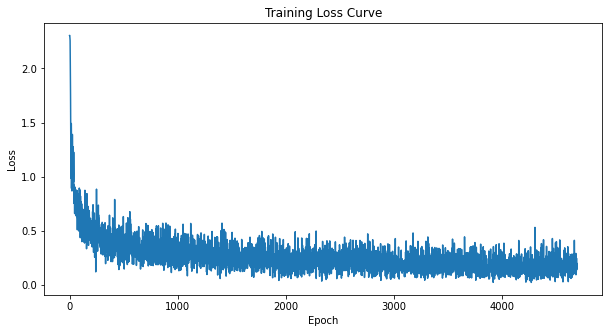

Test Accuracy:91.85 %


In [240]:
#| code-fold: false

import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_built() else "cpu")
print(f"device: {device}")
 

# Load and preprocess the Fashion MNIST dataset (just plain old standardization)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

model = SimpleCNN()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 5
all_losses = []
for epoch in range(num_epochs):
    model.train()
    epoch_losses = []
    for batch_idx, (data, targets) in enumerate(train_loader):
        data, targets = data.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {np.mean(epoch_losses):.4f}")
    all_losses.extend(epoch_losses)

# plot train loss curve
plt.figure(figsize=(10, 5))
plt.plot(all_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.show()

# Evaluation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data, targets in test_loader:
        data, targets = data.to(device), targets.to(device)
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
accuracy = 100 * correct / total
print(f'Test Accuracy:{accuracy:.2f} %')

Over 91% accuracy. Neat!! 
Now let's visualize some of the predictions.

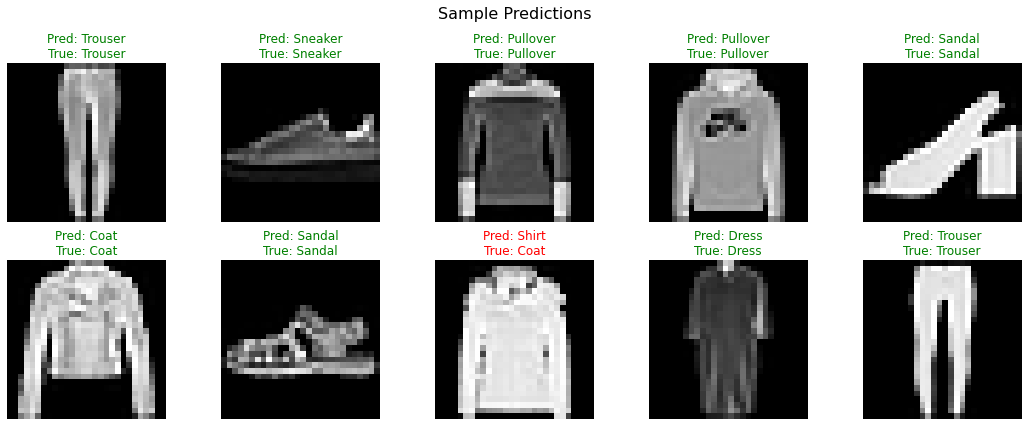

In [238]:
#| code-fold: false

import random

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']   # verify using train_dataset.classes

model.eval()
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Sample Predictions', fontsize=16)

with torch.no_grad():
    for i, idx in enumerate(random.sample(range(len(test_dataset)), 10)):
        image, label = test_dataset[idx]
        output = model(image.unsqueeze(0).to(device))
        predicted = output.argmax(1).item()
        
        ax = axes[i // 5, i % 5]
        ax.imshow(image.squeeze(), cmap='gray')
        ax.axis('off')
        ax.set_title(f'Pred: {class_names[predicted]}\nTrue: {class_names[label]}', 
                     color='green' if predicted == label else 'red')

plt.tight_layout()
plt.show()

Now let us visualize the confisuion matrix on the test set to analyse errors.

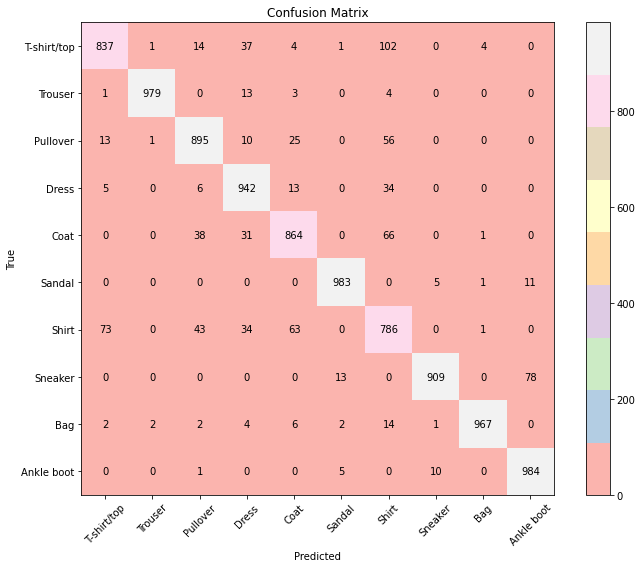

In [239]:
# see the confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Collect predictions and true labels
y_true, y_pred = [], []
model.eval()
with torch.no_grad():
    for data, targets in test_loader:
        data, targets = data.to(device), targets.to(device)
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(targets.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Create and plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap="Pastel1")
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = range(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted')
plt.ylabel('True')

# Add text annotations
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), ha="center", va="center")

plt.tight_layout()
plt.show()

We can see that the model is particularly confused in the "Tshirt" & "Shirt" class (less than 70% accuracy) and most confident in "Trouser", "Sneaker", "Bag" and "Ankle boot" (greater than 95% accuracy)


## Concluding

I hope you clearly understand the core CNN fundamental architecture. This is just the base that'll act as a foundation for more interesting architectures as we go on. Until then, see you in the next one!

Byeee :)

## Further Reading

- Sebastian Raschka Intorduction to CNNs course [here](https://sebastianraschka.com/blog/2021/dl-course.html#l13-introduction-to-convolutional-neural-networks)
- CS231N Cnn notes [here](https://cs231n.github.io/convolutional-networks/#case). Great intuition and more detail about the shapes, local connectivity, spatial arrangement, and loads of other stuff.
- A beginner friendly article on Medium (its a great blog-series for ML) [here](https://medium.com/@ageitgey/machine-learning-is-fun-part-3-deep-learning-and-convolutional-neural-networks-f40359318721)
- Visualizing and Understanding Convolutional Networks. 2014 paper [here](https://arxiv.org/pdf/1311.2901)
- Find out some of the modifications made on this basic architecture [here](https://towardsdatascience.com/10-papers-you-should-read-to-understand-image-classification-in-the-deep-learning-era-4b9d792f45a7)